In [2614]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import cv2
import sys
import os

In [2615]:
def scale_contour(cnt, scale):
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    cnt_norm = cnt - [cx, cy]
    cnt_scaled = cnt_norm * scale
    cnt_scaled = cnt_scaled + [cx, cy]
    cnt_scaled = cnt_scaled.astype(np.int32)
    return cnt_scaled

In [2616]:
def mask_holder(img):
      img = img.copy()
      blur = cv2.medianBlur(img, 5)
      gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
      _, tresh = cv2.threshold(gray, np.mean(gray), 255, cv2.THRESH_OTSU * cv2.THRESH_TRIANGLE)
      # ОПРЕДЕЛЕНИЕ И СОРТИРОВКА КОНТУРОВ
      contours, hierarchy = cv2.findContours(tresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      # В случае моножественных срезов ствола на снимке можно не выполнять сортировку или
      # прогнать ее в цикле
      cnt = sorted(contours, key=cv2.contourArea)[-1]
      s_contour = scale_contour(cnt, 1.05)
      # ПОСТРОЕНИЕ МАСКИ НА ИЗОБРАЖЕНИИ СОГЛАСНО СОРТИТРОВАННОй ОБЛАСТИ
      mask = np.zeros(img.shape[:2], dtype="uint8")
      # ИСХОДНАЯ МАСКА ОБЪЕКТА
      orignMask = cv2.bitwise_not(cv2.drawContours(mask, [cnt], -1, (255, 255, 255), -1))
      # УВЕЛМЧЕННАЯ МАСКА ОБЪЕКТА
      scaledMask = cv2.bitwise_not(cv2.drawContours(mask, [s_contour], -1, (255, 255, 255), -1))
      # ПРИМЕНЕИЕ УВЕЛИЧЕННОЙ МАСКИ К ИСХОДНОМУ ИЗОБРАЖЕНИЮ
      cnt_image = cv2.drawContours(img, [s_contour], -1, (255, 255, 255), -1)
      return orignMask, scaledMask, cnt_image

In [2617]:
def getBbox(img, width, height):
    contours, hierarchy = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    # Сортировка по площади контуров в порядке убывания.
    sorted_cnt = sorted(contours, key=cv2.contourArea, reverse = True)
    bboxes = []
    coordinates = ()
    box = []
    for cnt in sorted_cnt:
        x,y,w,h = cv2.boundingRect(cnt)
        bboxes.append((int(x), int(y), int((x + w)), int((y + h))))
    # Координаты x1, y1, x_center, y_center
    x0, y0, w0, h0 =  bboxes[1][0], bboxes[1][1], bboxes[1][2], bboxes[1][3]
    coordinates = (x0 + w0, y0 + h0, int(x0 + w0 / 2), int(y0 + h0 / 2))
    
    # Проверка левого края
    if ((x0 * 100) / width < 7): 
        x = int(math.ceil((x0 * 100) / width))
    else:
        x = int(coordinates[2] - (w0 / 2) * 1.1)

    # Проверка верхнего края
    if ((y0 * 100) / height < 7):
        y = int(math.ceil((y0 * 100) / height))
    else:
        y = int(coordinates[3] - (h0 / 2) * 1.1)
    
    # Проверка правого края
    if ((coordinates[0] * 100) / width < 100):
        xw = width - x
    else:
        xw = int(coordinates[3] + (w0 / 2) * 1.2)
    
    # Проверка нижнего края
    if ((coordinates[1] * 100) / height < 105):
        yh = height - y
    else:
        yh = int(coordinates[3] + (h0 / 2) * 1.5)
    
    # Определение зоны внимания
    box.append((x, y, xw, yh))
    return box

In [2618]:
# НАХОЖДЕНИЕ СРЕДНЕНГО ЗНАЧЕНИЯ ЦВЕТА ПИКСЕЛЯ В МАСКИРОВАННОМ ИЗОБРАЖЕНИИ
def average_pixel_color(img):
    i = img.copy()
    g = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
    ig = np.where((g > 0), 0, 1).astype('uint8')
    m = np.mean(ig) * 255 #* 100
    return m 

In [2619]:
# ОТРИСОВКА ЗОНЫ ВНИМАНИЯ НА СНИМКЕ
def draw_annotations(img, bbox, thickness=2, color=(0,255,255)):
    annotations = img.copy()
    xCoor = (bbox[0][0], bbox[0][1])
    yCoor = (bbox[0][2], bbox[0][3])
    cv2.rectangle(annotations, xCoor, yCoor, color, thickness, cv2.LINE_AA)
    return annotations

In [2620]:
# ВЫДЕЛЕНИЕ ЗАДНЕГО ФОНА ПО МАСКЕ/ПО ЗОНЕ ВНИМАНИЯ (GRABCUT)
def GrabCut(image, mask, rect, iteration = 4, mode = 0):
    fgModel = np.zeros((1, 65), np.float64)
    bgModel = np.zeros((1, 65), np.float64)

    match mode:
        case(0):
            mode = cv2.GC_INIT_WITH_MASK
        case(1):
            mode = cv2.GC_INIT_WITH_RECT
    

    mask, bgModel, fgModel = cv2.grabCut(image, mask, rect, bgModel, fgModel, iterCount=iter, mode=mode)
    return mask, bgModel, fgModel

In [2621]:
def post_CG(mask, image):
    values = (cv2.GC_BGD, cv2.GC_PR_BGD, cv2.GC_FGD, cv2.GC_PR_FGD)
    for value in values: valueMask = (mask == value).astype("uint8") * 255
    outputMask = np.where((mask == cv2.GC_PR_BGD) | (mask == cv2.GC_BGD), 0, 1).astype('uint8') * 255
    output = cv2.bitwise_and(image, image, mask=outputMask)
    return output

[ИНФО] Время выполнения 2.07 сек.
Координаты зоны внимания:  (5, 7, 593, 596)
Общий объем изображения:  261278
Общий объем изображения коры:  49499
Объем коры в %:  18.945 %


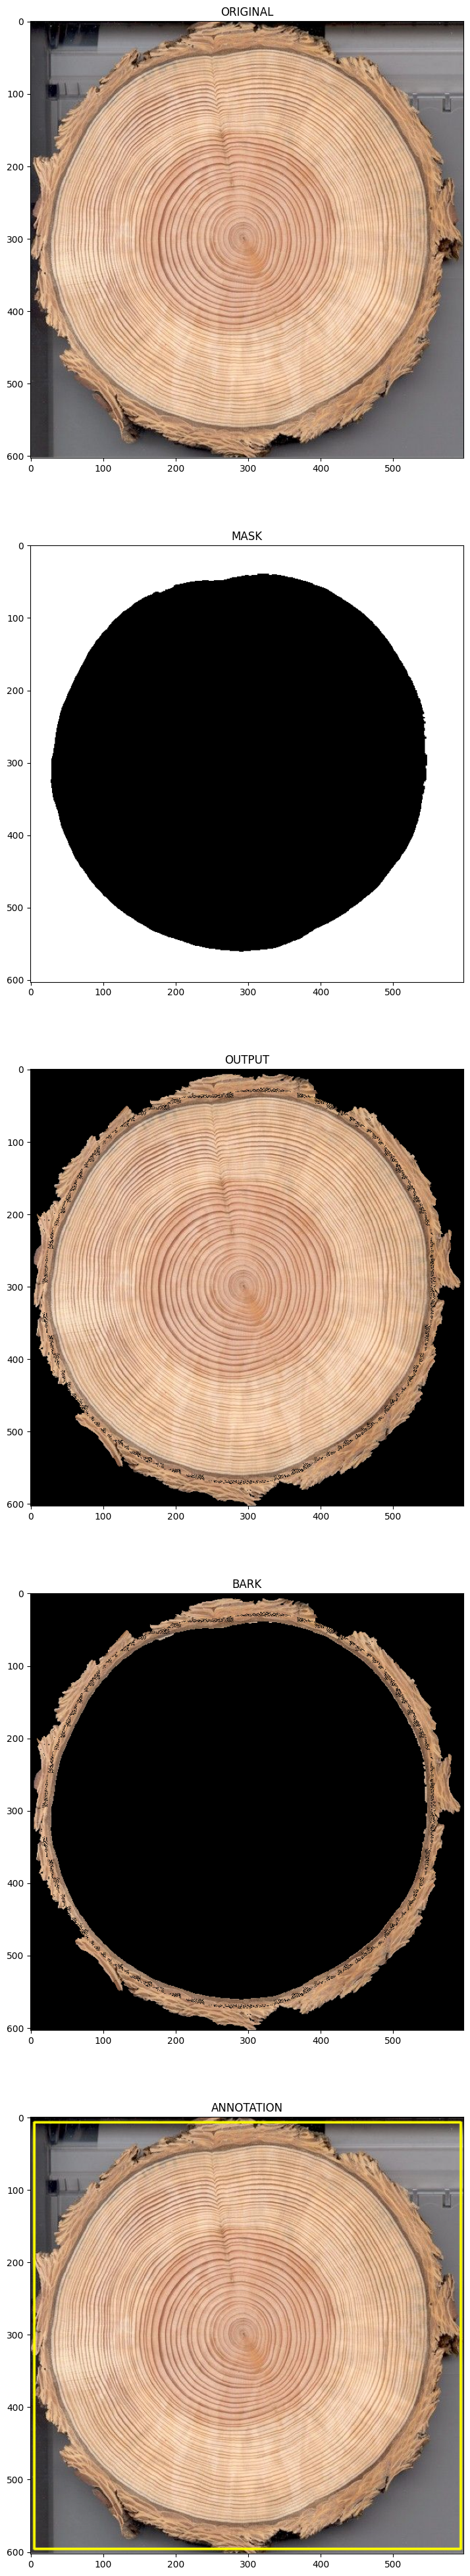

In [2622]:
filename = input('Введите порядковый номер файла:')
iter = int(input('Введите количество итераций:'))

# ЗАГРУЗКА ОРИГИНАЛА ИЗОБРАЖЕНИЯ И ФОРМИРОВАНИЕ МАСКИ НА ЕГО ОСНОВЕ
image = cv2.imread('images/' + filename + '.jpg')
height, width = image.shape[:2]
mask_origin, mask_scaled, cnt_image = mask_holder(image)

cv2.imwrite('images/masks/cnt/' + filename + '.jpg', cnt_image)

mask = np.zeros(image.shape[:2], np.uint8)

# ОПРЕДЕЛЕНИЕ ЗОНЫ ВНИМАНИЯ ДЛЯ GRABCUT
# rect = (x, y, x1, y1)
grab_image = cv2.imread('images/masks/cnt/' + filename + '.jpg', cv2.IMREAD_GRAYSCALE)
box = getBbox(mask_origin, width, height)
rect = (box[0])
annotation = draw_annotations(image, box)

i_o = cv2.bitwise_and(image, image, mask=mask_scaled)

gi_b = average_pixel_color(i_o)
gi_f = int((255 + gi_b) / 2)

mask[grab_image == 255] = cv2.GC_FGD
mask[grab_image <= gi_f] = cv2.GC_PR_FGD
mask[grab_image <= gi_b] = cv2.GC_PR_BGD
mask[grab_image == 0] = cv2.GC_BGD

start = time.time()
mask, f, b = GrabCut(image, mask, rect, iter, 0) # mode = 0 for mask mode, mode = 1 for rect mode

output = post_CG(mask, image)

mask[mask > 0] = cv2.GC_FGD
mask[mask == 0] = cv2.GC_BGD
mask, f, b = GrabCut(output, mask, rect, iter, 1) # mode = 0 for mask mode, mode = 1 for rect mode
end = time.time()

output = post_CG(mask, image)

summary_area = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
blur = cv2.medianBlur(summary_area, 3)
total_area = cv2.threshold(blur,0,255,cv2.THRESH_OTSU + cv2.THRESH_BINARY)[1]

roughOutput = cv2.bitwise_and(output, output, mask=mask_origin)

bark_area = cv2.cvtColor(roughOutput, cv2.COLOR_BGR2GRAY)
blur = cv2.medianBlur(bark_area, 3)
total_bark_area = cv2.threshold(blur,0,255,cv2.THRESH_OTSU + cv2.THRESH_BINARY)[1]

t_area = cv2.countNonZero(total_area)
t_bark_area = cv2.countNonZero(total_bark_area)

# ОТОБРАЖЕНИЕ РЕЗУЛЬТАТОВ РАБОТЫ
print("[ИНФО] Время выполнения {:.2f} сек.".format(end - start))
print('Координаты зоны внимания: ', box[0])
print('Общий объем изображения: ', t_area)
print('Общий объем изображения коры: ', t_bark_area)
print('Объем коры в %: ', round(t_bark_area*100/t_area, 3), '%')

fig, axs = plt.subplots(5)
fig.set_figwidth(20)
fig.set_figheight(50)
axs[0].set_title('ORIGINAL')
axs[0].imshow(image[:, :, ::-1])
axs[1].set_title('MASK')
axs[1].imshow(mask_origin, cmap='gray', vmin=0, vmax=255)
axs[2].set_title('OUTPUT')
axs[2].imshow(output[:, :, ::-1])
axs[3].set_title('BARK')
axs[3].imshow(roughOutput[:, :, ::-1])
axs[4].set_title('ANNOTATION')
axs[4].imshow(annotation[:, :, ::-1])

#ЗАПИСЬ ФАЙЛОВ В ПАПКИ
cv2.imwrite('images/thresh/' + filename + '.jpg', output)
cv2.imwrite('images/masks/mask_' + filename + '.jpg', mask_origin)

cv2.waitKey(0)
cv2.destroyAllWindows()